## Vector quantization

Most vector embeddings are stored as floating point numbers (64-bit in Python). We can use **quantization** to reduce the size of the embeddings.

In [1]:
# Load in the vectors from movies.json, {movie: [vector]}
import json

with open('openai_movies.json') as f:
    movies = json.load(f)

In [17]:
import sys

sys.getsizeof(movies['Moana'])

12728

In [27]:
# Quantize all the vectors to 1 byte
import numpy as np


def quantize_vector(vec, reduction_factor):
    """Turn a float64 into a int8"""
    # add 1 to each value to make them all positive
    vec = np.array(vec) + 1
    # clip values to [0, 2]
    vec = np.clip(vec, 0, 2)
    # multiply by 127 to get [0, 254]
    vec = vec * 127
    # convert to int8
    vec = vec.astype(np.int8)
    return vec

movies_1byte = {k: quantize_vector(v, 4) for k, v in movies.items()}
movies_1byte

{'Snow White and the Seven Dwarfs': array([ 124,  122,  124, ..., -128,  126,  123], dtype=int8),
 'Pinocchio': array([ 125,  125, -127, ..., -126,  127,  124], dtype=int8),
 'Fantasia': array([-128,  125,  127, ...,  126,  127,  123], dtype=int8),
 'Song of the South': array([123, 123, 125, ..., 125, 127, 126], dtype=int8),
 'Cinderella': array([126, 123, 126, ..., 127, 126, 127], dtype=int8),
 '20,000 Leagues Under the Sea': array([-128,  124, -127, ...,  124,  126,  122], dtype=int8),
 'Lady and the Tramp': array([123, 125, 126, ..., 126, 127, 123], dtype=int8),
 'Sleeping Beauty': array([ 125,  124,  127, ..., -126,  126,  125], dtype=int8),
 '101 Dalmatians': array([126, 126, 124, ..., 126, 125, 124], dtype=int8),
 'The Absent Minded Professor': array([124, 127, 127, ..., 124, 126, 123], dtype=int8),
 'Babes in Toyland': array([ 123,  123,  125, ..., -128,  125,  124], dtype=int8),
 'Bon Voyage!': array([-127,  125, -128, ...,  124,  126,  125], dtype=int8),
 'The Sword in the Sto

In [32]:
# 10 most similar movies to Moana
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['movie', 'similarity'])
    return df

most_similar('Moana', movies_1byte)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.586930
2,The Little Mermaid,0.584901
3,Hannah Montana the Movie,0.564100
4,Finding Nemo,0.544544
5,Lilo & Stitch,0.541320
6,Aladdin,0.535251
7,Maleficent,0.531076
8,Beauty and the Beast,0.529990
9,Finding Dory,0.528844


In [33]:
most_similar('Moana', movies)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.905926
2,The Little Mermaid,0.877542
3,Aladdin,0.864455
4,Pocahontas,0.862812
5,Hannah Montana the Movie,0.860928
6,Lilo & Stitch,0.858802
7,Cinderella,0.858162
8,Tangled,0.858131
9,Maleficent,0.856232


## Binary quantization

The most extreme form of quantization is to store the embeddings as binary numbers, setting each dimension to 0 or 1, based on a threshold.

In [42]:
def quantize_vector(vec, threshold):
    """Turn a float32 into a bit by thresholding at 0"""
    vec = np.array(vec)
    vec = (vec > threshold).astype(np.int8)
    return vec

# calculate the mean of all the dimensions of each vector
mean_vec = np.mean(np.mean(list(movies.values()), axis=0))

movies_1bit = {k: quantize_vector(v, mean_vec) for k, v in movies.items()}
movies_1bit

{'Snow White and the Seven Dwarfs': array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
 'Pinocchio': array([0, 0, 1, ..., 1, 1, 0], dtype=int8),
 'Fantasia': array([1, 0, 1, ..., 0, 1, 0], dtype=int8),
 'Song of the South': array([0, 0, 0, ..., 0, 1, 0], dtype=int8),
 'Cinderella': array([0, 0, 0, ..., 1, 0, 1], dtype=int8),
 '20,000 Leagues Under the Sea': array([1, 0, 1, ..., 0, 0, 0], dtype=int8),
 'Lady and the Tramp': array([0, 0, 1, ..., 0, 1, 0], dtype=int8),
 'Sleeping Beauty': array([0, 0, 1, ..., 1, 1, 0], dtype=int8),
 '101 Dalmatians': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'The Absent Minded Professor': array([0, 1, 1, ..., 0, 0, 0], dtype=int8),
 'Babes in Toyland': array([0, 0, 0, ..., 1, 0, 0], dtype=int8),
 'Bon Voyage!': array([1, 0, 1, ..., 0, 1, 0], dtype=int8),
 'The Sword in the Stone': array([1, 0, 0, ..., 0, 1, 0], dtype=int8),
 'The Jungle Book': array([0, 0, 1, ..., 0, 1, 0], dtype=int8),
 "Blackbeard's Ghost": array([0, 0, 1, ..., 1, 0, 1], dtype=int8),
 'The 

In [38]:
most_similar('Moana', movies_1bit)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.797453
2,Lilo & Stitch,0.766315
3,The Little Mermaid,0.762547
4,Hannah Montana the Movie,0.761729
5,Pocahontas,0.754125
6,Big Hero 6,0.754006
7,Disney Planes,0.746025
8,Tangled,0.745110
9,Finding Nemo,0.742330


## Visualizing the quantization

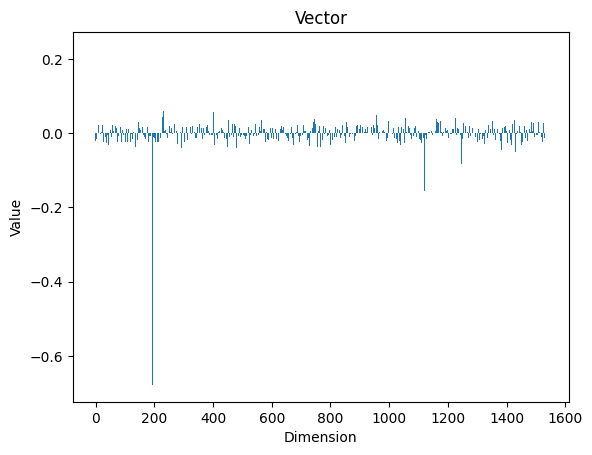

In [50]:
# make a chart of a single vector
import matplotlib.pyplot as plt

vector = movies['Moana']
plt.bar(range(len(vector)), vector)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

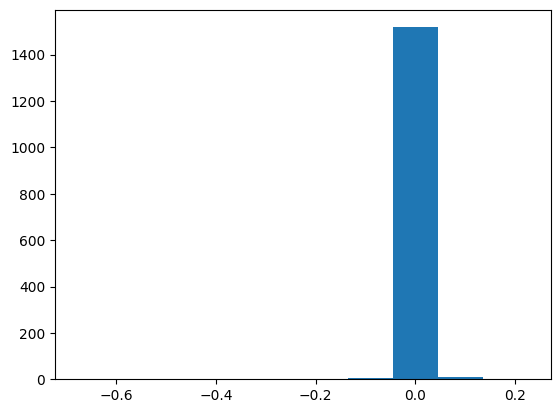

In [51]:
# make a histogram of a single vector
plt.hist(movies['Moana'])
plt.show()

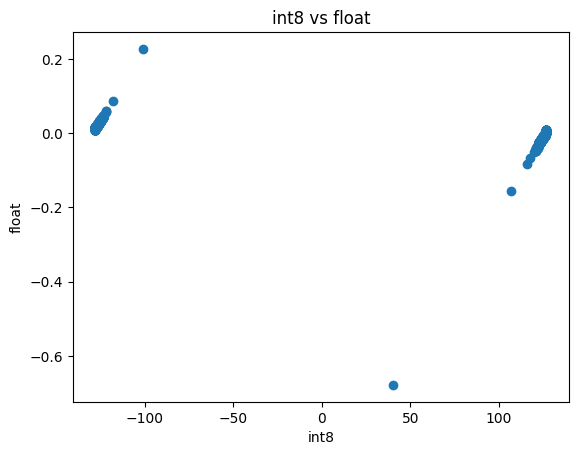

In [56]:
# Compare the 1bit and 1byte vectors in a 2d plot
plt.scatter(movies_1byte['Moana'], movies['Moana'])
plt.xlabel('int8')
plt.ylabel('float')
plt.title('int8 vs float')
plt.show()

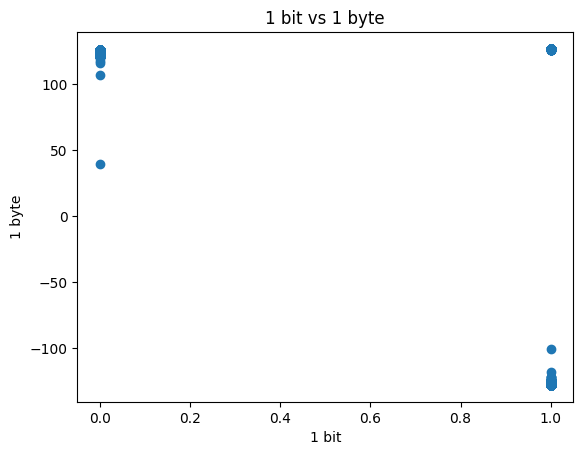

In [55]:
# Compare the 1bit and 1byte vectors in a 2d plot
plt.scatter(movies_1bit['Moana'], movies_1byte['Moana'])
plt.xlabel('1 bit')
plt.ylabel('1 byte')
plt.title('1 bit vs 1 byte')
plt.show()

## Size comparison

In [40]:
# Compare the sizes of the quantized vectors

pd.DataFrame({
    'float64': [sys.getsizeof(movies['Moana'])],
    'int8': [sys.getsizeof(movies_1byte['Moana'])],
    'int1': [sys.getsizeof(movies_1bit['Moana'])],
})

,float32,int8,int1
0,12728,1648,1648


In [44]:
sys.getsizeof(movies['Moana'])/sys.getsizeof(movies_1byte['Moana'])

7.723300970873787